In [1]:
from setup import general
from setup import stat
from setup import r

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

from scipy import stats
import sqlite3
import pingouin as pg
from pingouin import ancova # anconva
from pingouin import multivariate_normality # for pearson correlation
import rpy2.robjects as robjects # use basic R function

In [2]:
%store -r Scale_corr nreps

/home/jzni/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
def get_dt(index):    
    return corr_list[index]

def set_matrix_value(matrix,x_label, y_label, value):
    matrix.loc[x_label,y_label] = value
    matrix.loc[y_label,x_label] = value
        

# Analysis
患者前测行为评分之间的相互关系

In [4]:
# pearson correlation test


corr_list = Scale_corr.columns[1:-1] # scales that need correlation test

# Patients' correlation matrix
pt_coefficient_matrix = pd.DataFrame(np.zeros(676).reshape(26,26), index=corr_list, columns=corr_list)
pt_p_matrix = pd.DataFrame(np.zeros(676).reshape(26,26), index=corr_list, columns=corr_list)
pt_coefficient_matrix_partial = pt_coefficient_matrix.copy()
pt_p_matrix_partial = pt_p_matrix.copy()
pt_norm_matrix = pt_coefficient_matrix.copy()


DF_pt = Scale_corr # More readable
for i in range(len(corr_list)):
    for j in range(len(corr_list)-i):
        if i == j+i:
            pt_coefficient_matrix.iloc[i,j+i] = 1
            pt_p_matrix.iloc[i,j+i] = 0
            pt_coefficient_matrix_partial.iloc[i,j+i] = 1
            pt_p_matrix_partial.iloc[i,j+i] = 0
            continue        
        
        x_label = get_dt(i)
        y_label = get_dt(j+i)
        df = DF_pt[[x_label, y_label,'Age']]
        # drop any row with missing value 
        df = df.dropna(how='any',axis=0) 
        
        # 多元正态检验, 1 代表通过 用pearson  0 则用spearman
        norm_bool = 1 if multivariate_normality(df[[x_label, y_label]])[2] else 0
        set_matrix_value(pt_norm_matrix, x_label, y_label, norm_bool)
        
        pccs = stats.pearsonr(df[x_label], df[y_label]) if norm_bool else stats.spearmanr(df[x_label], df[y_label])
        set_matrix_value(pt_coefficient_matrix, x_label, y_label, round(pccs[0],4))
        set_matrix_value(pt_p_matrix, x_label, y_label, round(pccs[1],4))
        
        pccs1 = stat.partial_corr(df[x_label], df[y_label], partial = df['Age'])
        set_matrix_value(pt_coefficient_matrix_partial, x_label, y_label, round(pccs1[0],4))
        set_matrix_value(pt_p_matrix_partial, x_label, y_label, round(pccs1[1],4))

        

In [ ]:
print("p value of pearson correlation test:")
%store pt_norm_matrix pt_p_matrix  pt_p_matrix_partial pt_coefficient_matrix pt_coefficient_matrix_partial

# Plot
## Heatmap

<AxesSubplot:>

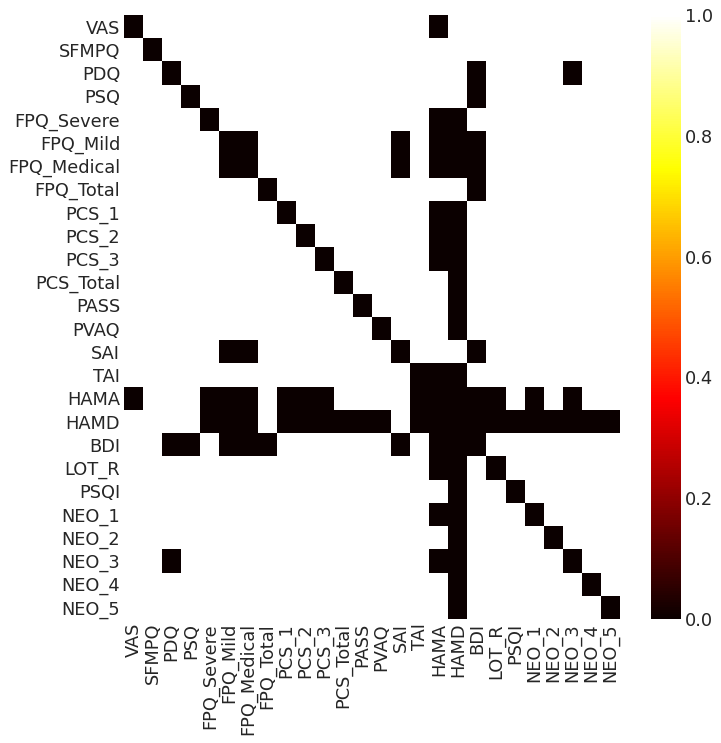

In [6]:
# Figure settings
large = 22; med = 16; small = 12
params = {'axes.titlesize': large, 'legend.fontsize': med,  'figure.figsize': (16, 10), 'axes.labelsize': med,
          'axes.titlesize': med,   'xtick.labelsize': med,  'ytick.labelsize': med,  'figure.titlesize': large}

plt.figure(figsize=(10,10), dpi= 80)
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.rcParams['axes.unicode_minus'] = False 
sns.heatmap(pt_norm_matrix, cmap='hot')

<AxesSubplot:>

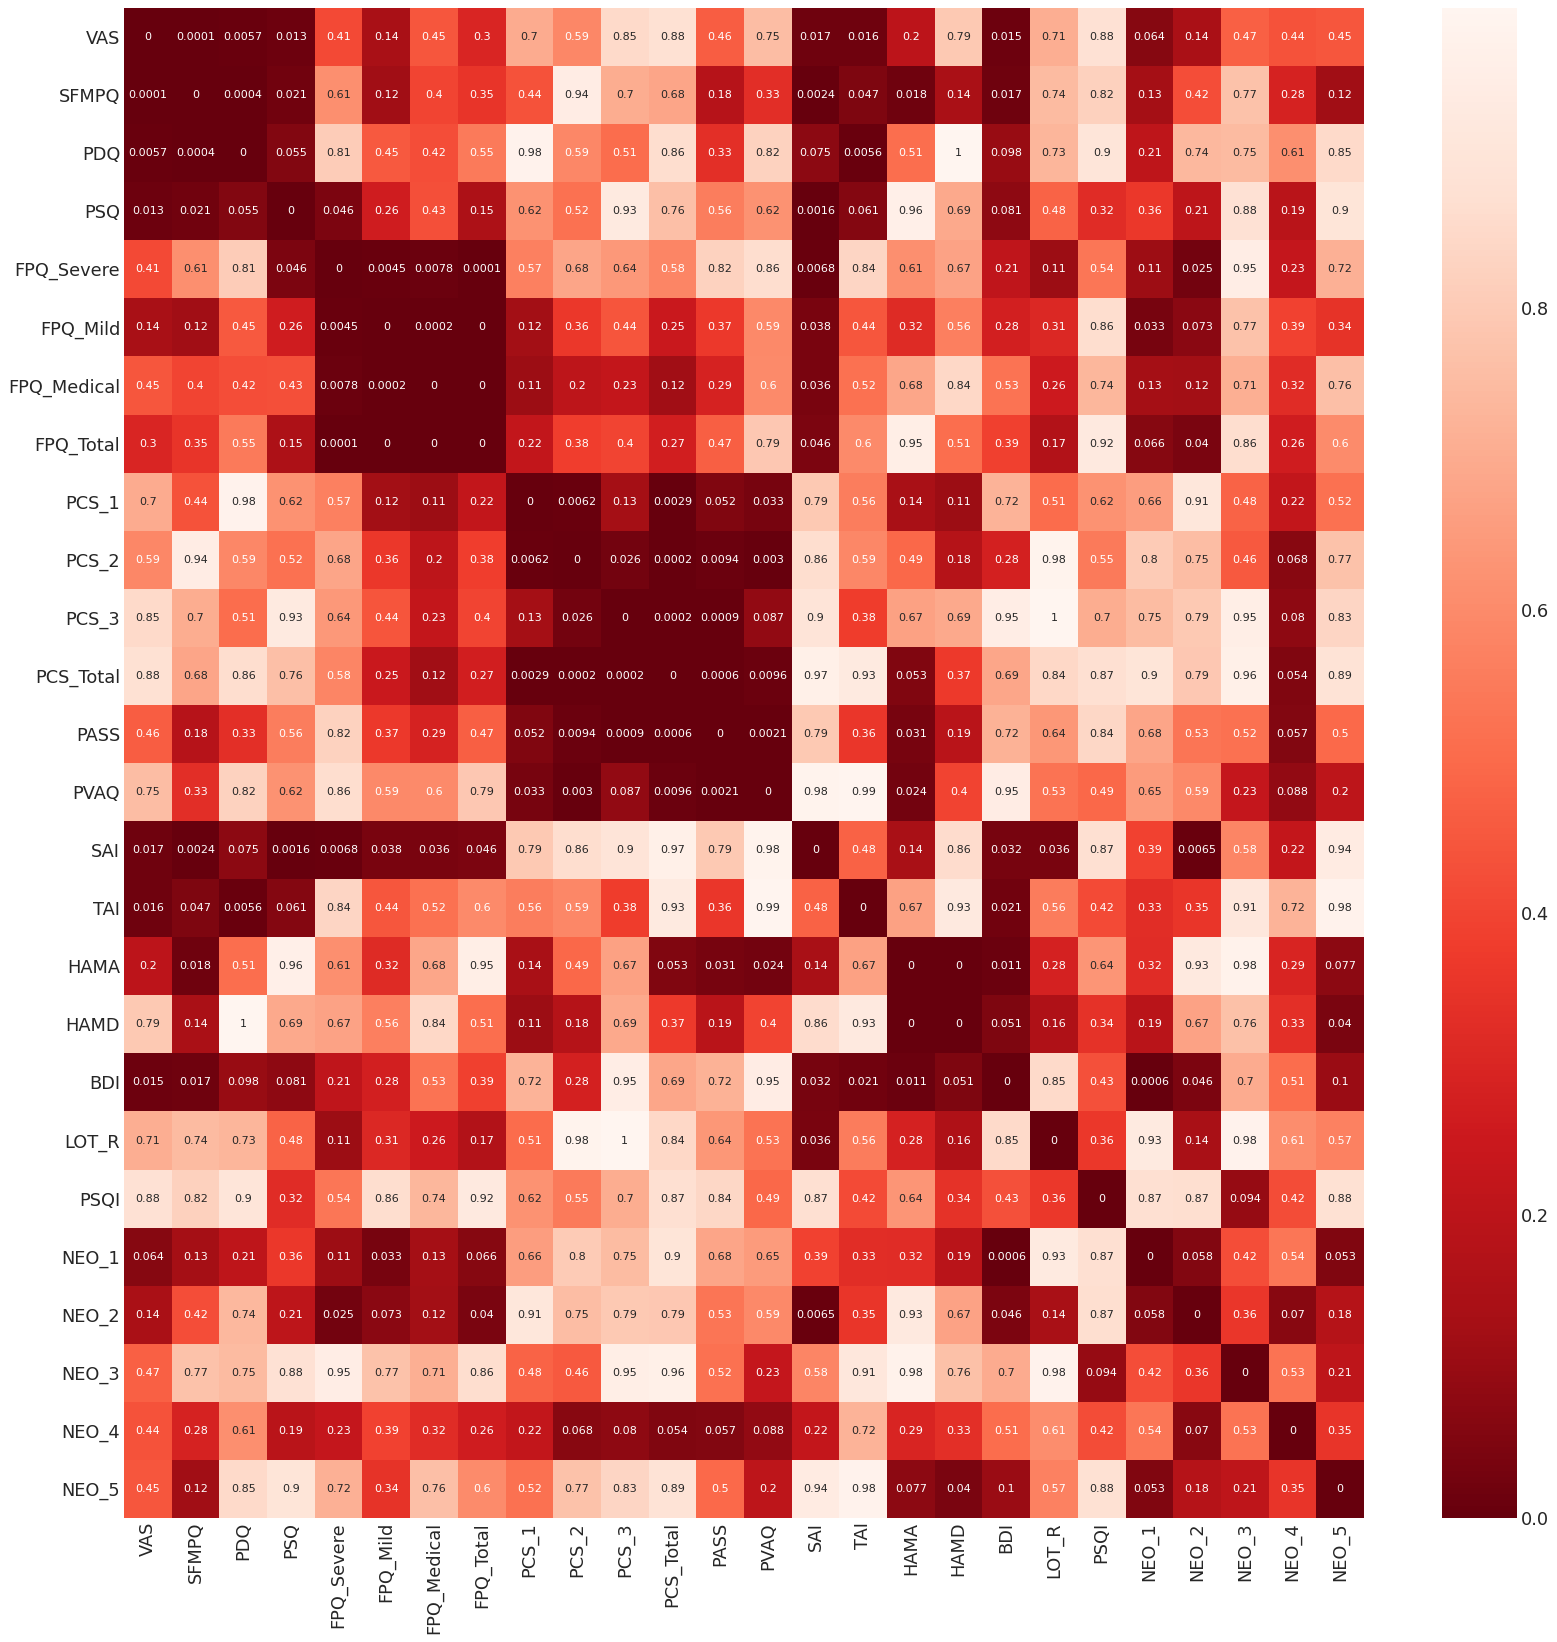

In [7]:
plt.figure(figsize=(25,25), dpi= 80)
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.rcParams['axes.unicode_minus'] = False 

sns.heatmap(pt_p_matrix, cmap='Reds_r', annot=True)

<AxesSubplot:>

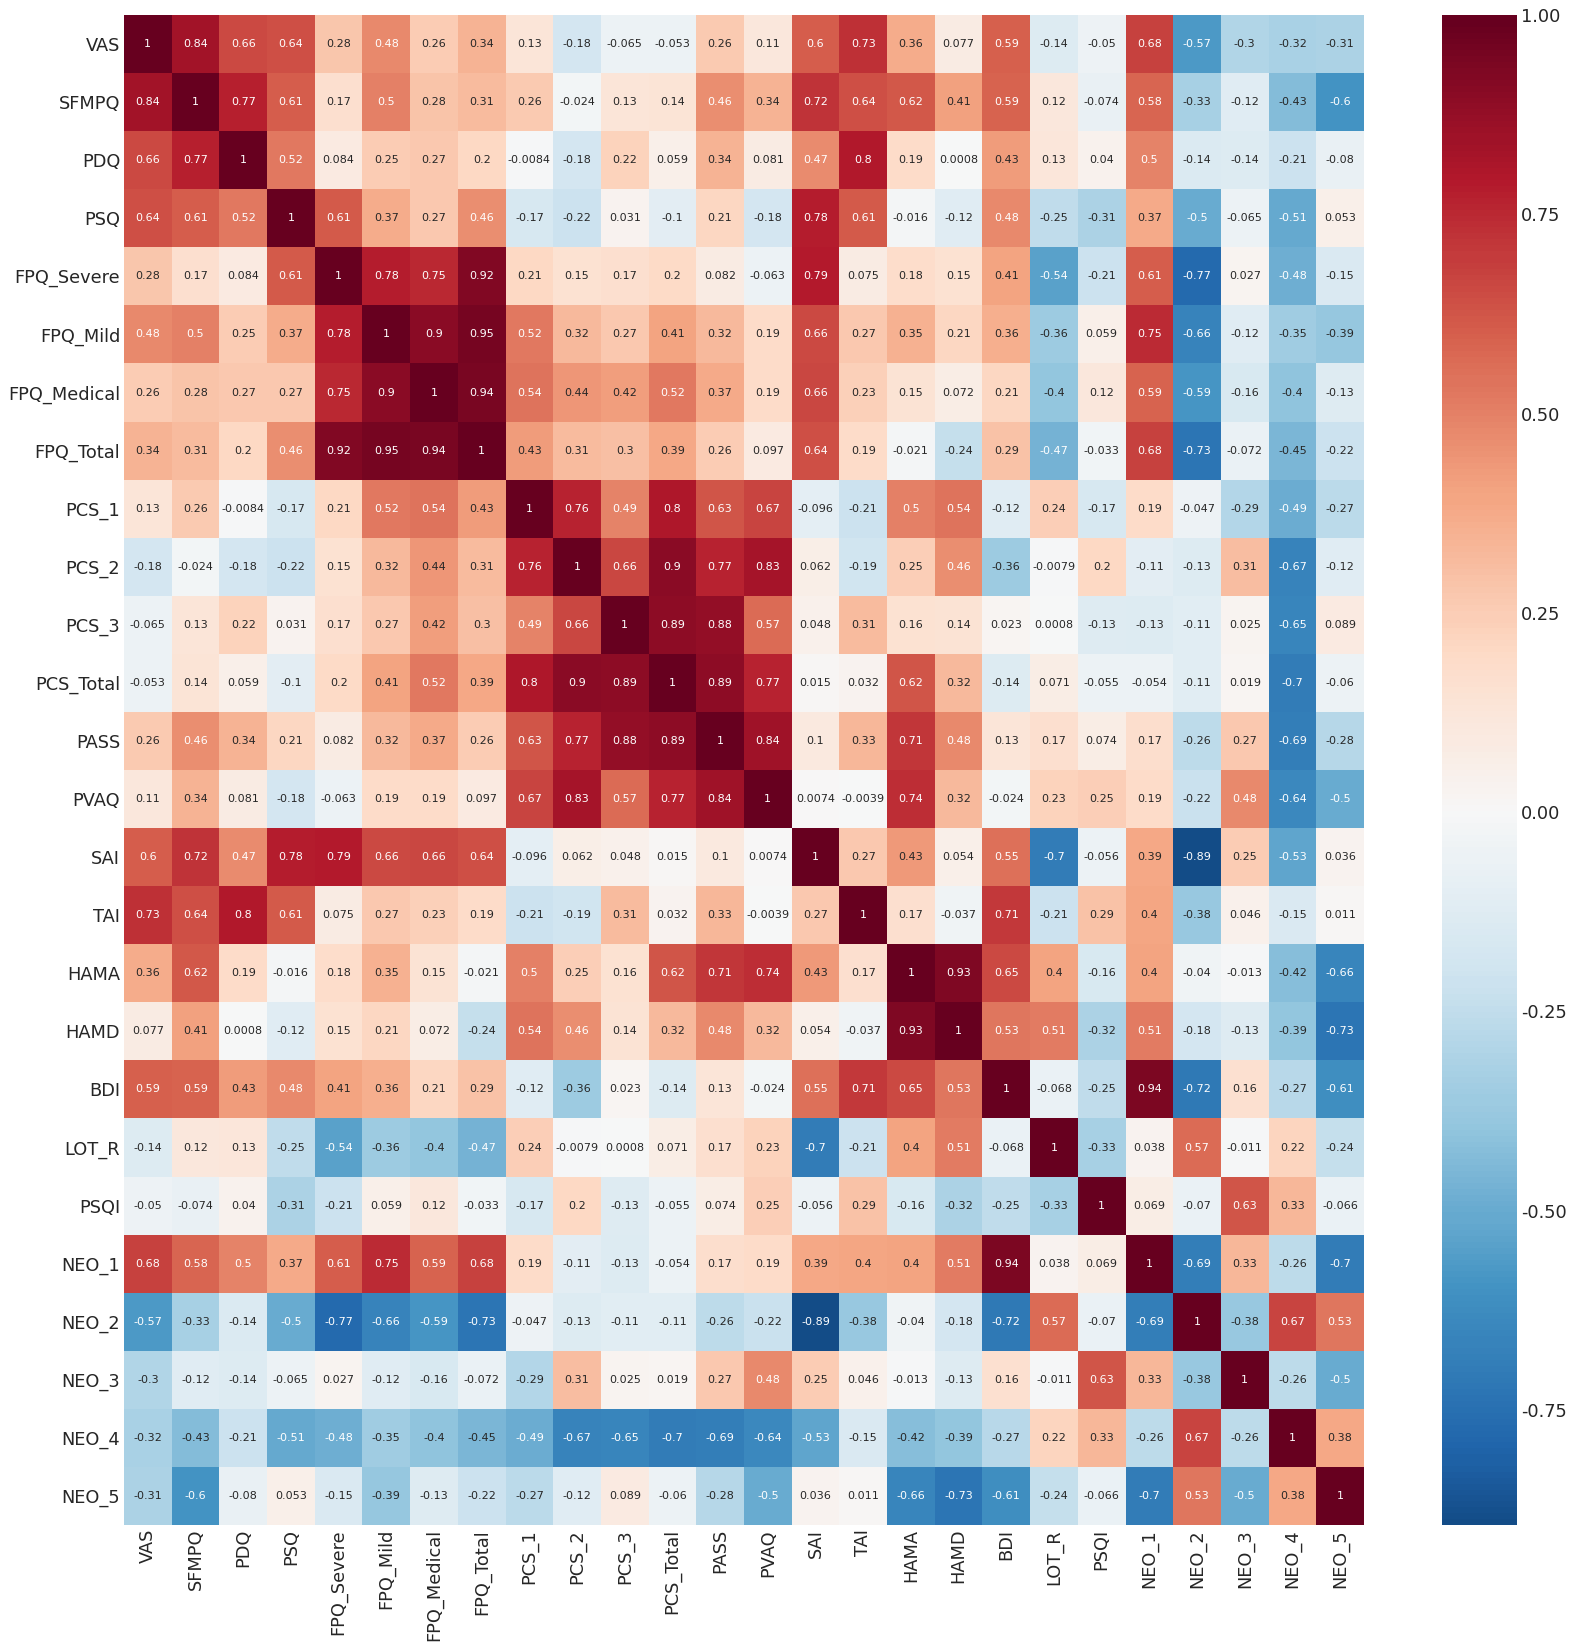

In [8]:
plt.figure(figsize=(25,25), dpi= 80)

plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.rcParams['axes.unicode_minus'] = False  

sns.heatmap(pt_coefficient_matrix, cmap='RdBu_r', center=0, annot=True)

偏相关分析（年龄作为协变量）结果的heatmap

<AxesSubplot:>

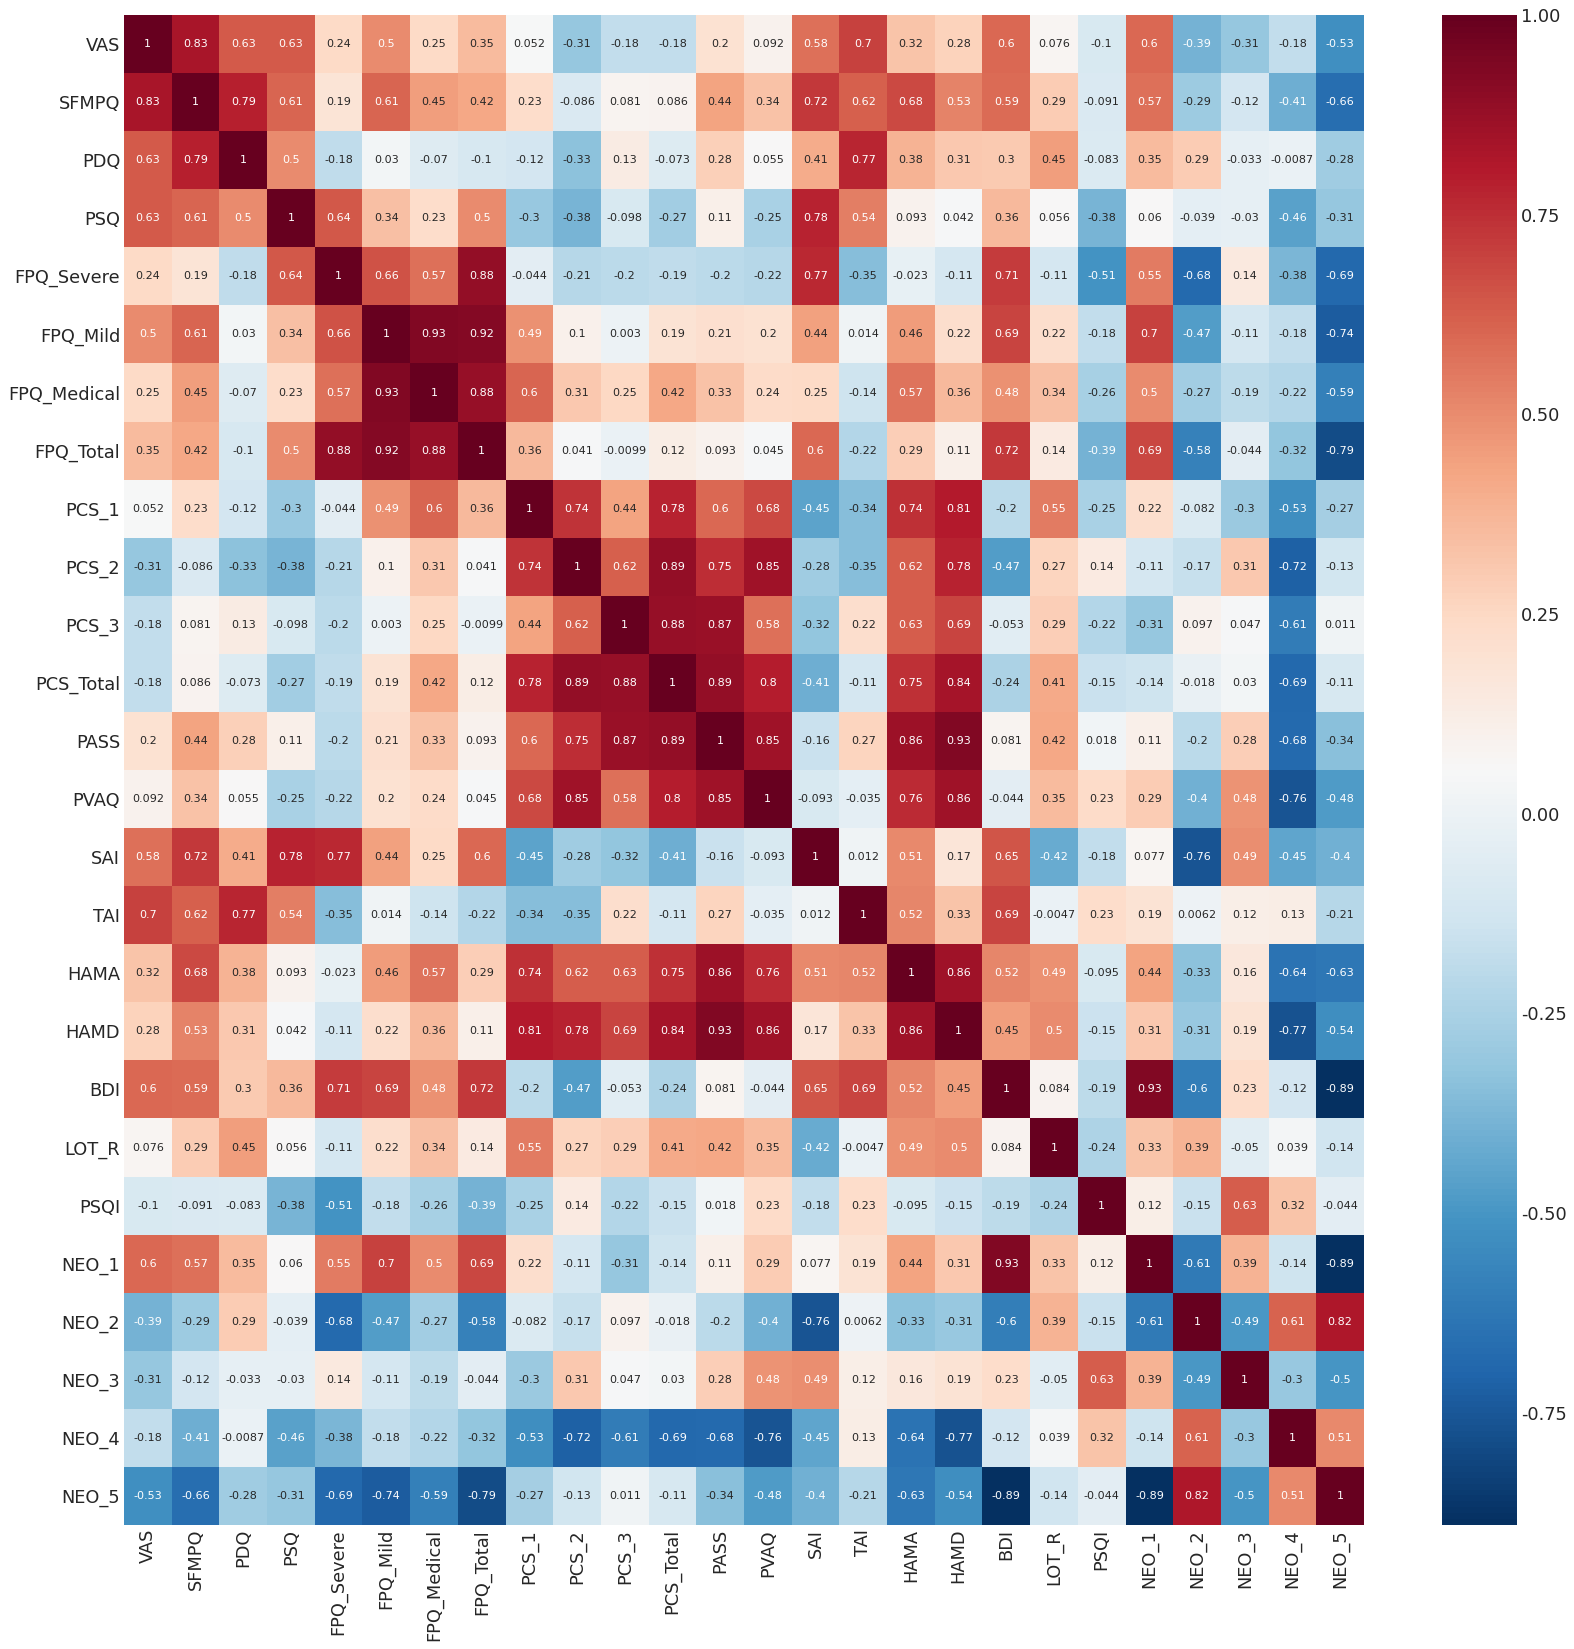

In [9]:
plt.figure(figsize=(25,25), dpi= 80)
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.rcParams['axes.unicode_minus'] = False 
sns.heatmap(pt_coefficient_matrix_partial, cmap='RdBu_r', annot=True)

## regression plot

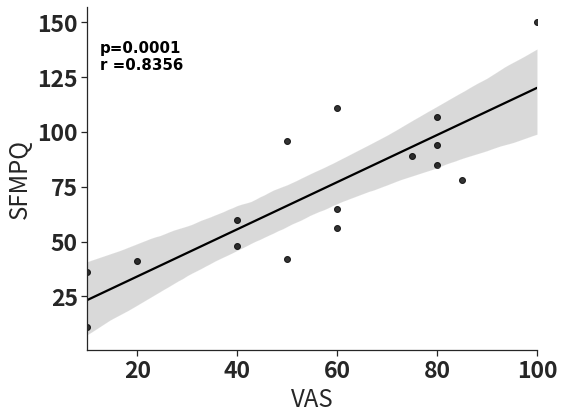

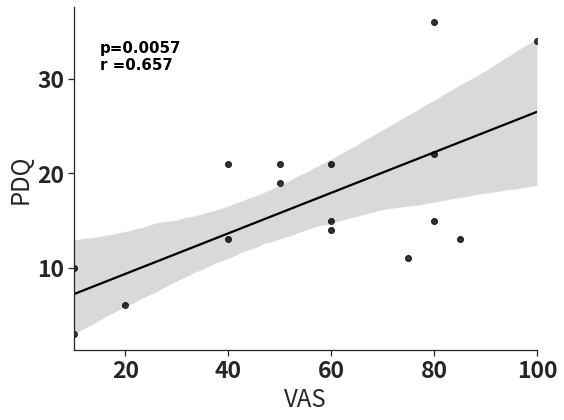

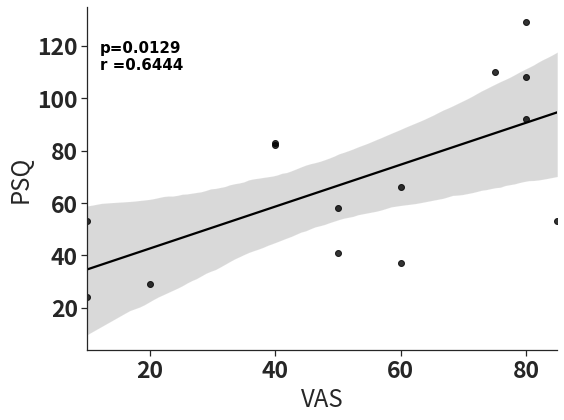

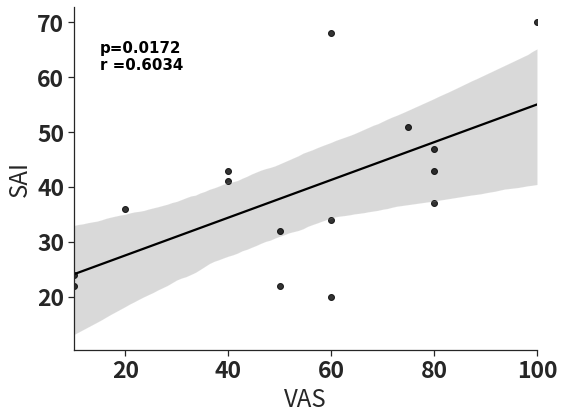

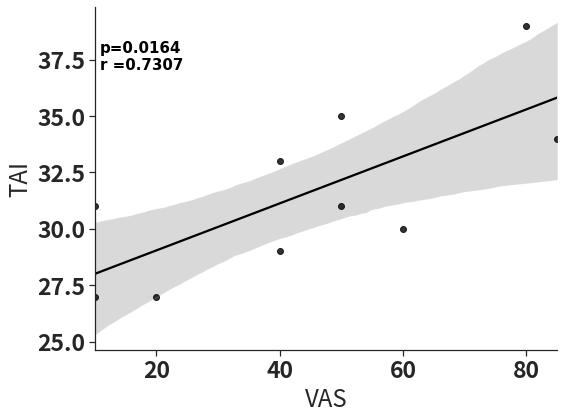

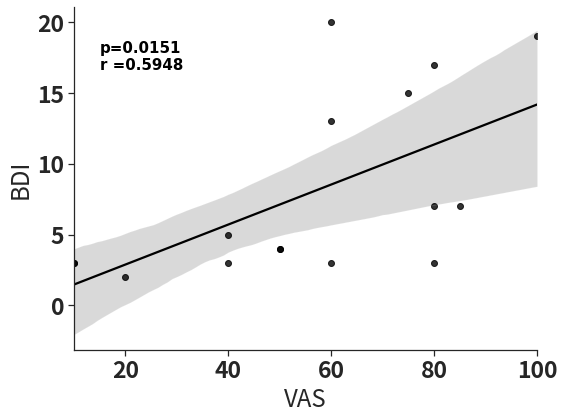

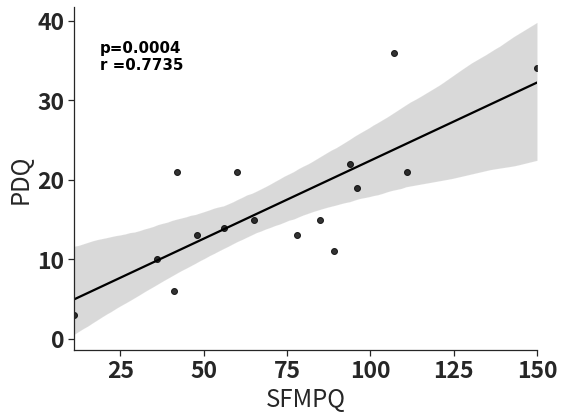

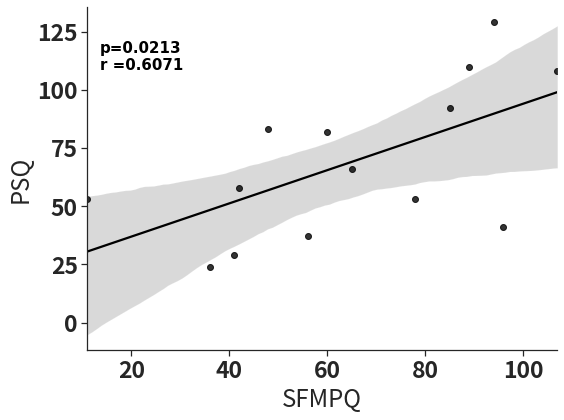

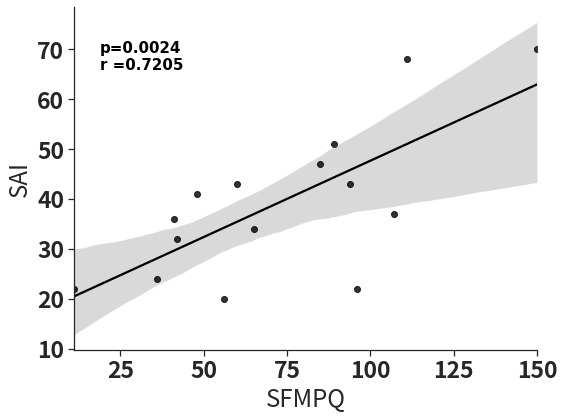

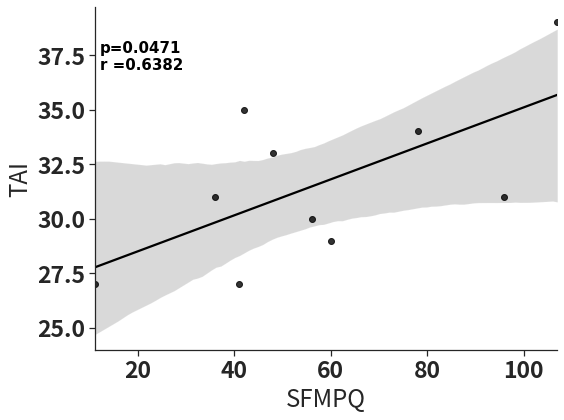

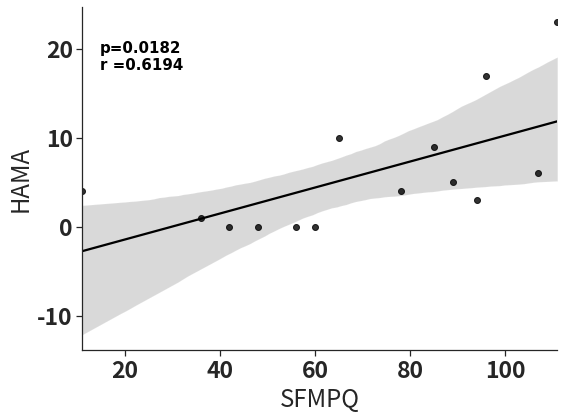

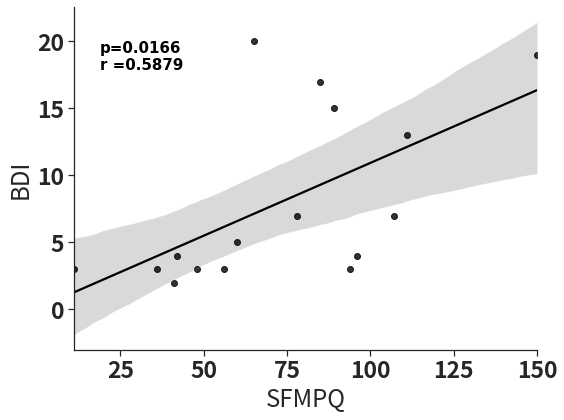

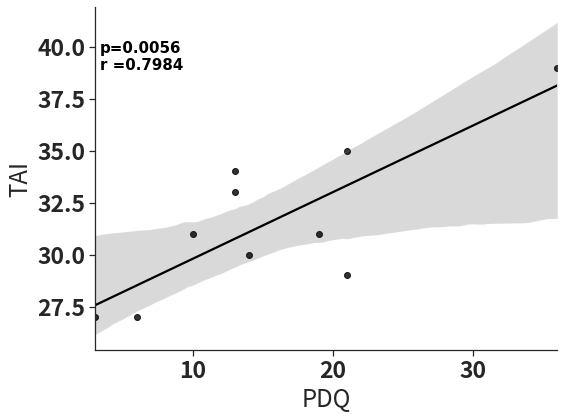

In [10]:
for i in range(len(corr_list)):
    for j in range(len(corr_list)-i):
        if i == j+i:
            continue
        x_label = get_dt(i)
        y_label = get_dt(j+i)        
        df = DF_pt[[x_label, y_label,'Age']]
        df = df.dropna(how='any',axis=0) # drop any row with missing value to prevent overfit
        if pt_p_matrix.loc[x_label, y_label] <0.05:
            if i in [0,1, 2] :
                plt.figure(figsize=(8,6))
                '''decorate image'''
                sns.set(font_scale=2)
                sns.set_style("white")
                plt.rcParams["font.weight"] = "bold"
                plt.rcParams["font.family"] = 'Noto Sans CJK JP'
                
                ax = plt.gca()      #gca='get current axis'
                # 将右边和上边的边框（脊）的颜色去掉
                ax.spines['right'].set_color('none')
                ax.spines['top'].set_color('none')

                # 绑定x轴和y轴
                ax.xaxis.set_ticks_position('bottom')
                ax.yaxis.set_ticks_position('left')
                sns.set(color_codes=True)
                
                sns.regplot(x=x_label, y=y_label, data=df,color='black')
                if pccs[0] <= 0:
                    plt.annotate("p ={}\nr={}".format(round(pt_p_matrix.loc[x_label, y_label],4),pt_coefficient_matrix.loc[x_label, y_label])
                             , xy=(500, 350), xycoords='figure points',fontsize=15,color="black")
                else:
                    plt.annotate("p={}\nr ={}".format(round(pt_p_matrix.loc[x_label, y_label],4),pt_coefficient_matrix.loc[x_label, y_label])
                             , xy=(100, 350), xycoords='figure points',fontsize=15,color="black")
                plt.tick_params(labelsize=23)
                plt.tight_layout()
                plt.show()
